# NLP ASSIGNMENT

NAME: Dadireddy Jahnavi <br>
ROLL NO: B190181EC <br>
BATCH: ECE-A

**Write the python code for sentiment analysis for the following dataset. Do the required pre-processing - stemming, punctuation removal, term frequency etc. - (whichever required). Then design a classifier to categorize the reviews / texts using logistic regression and naive bayes classifier. Also generate required plots and confusion matrix.**

1) Use the twitter data from the nltk library in python

## BASIC IMPORTS (MODULES AND DATA)

In [16]:
# importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import nltk                                 
from nltk.corpus import twitter_samples  

# importing twitter data using nltk 
# downloads sample twitter dataset.
nltk.download('twitter_samples')

# download the stopwords for the process_tweet function
nltk.download('stopwords')

import re                                  # library for regular expression operations
import string                              # for string operations
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/kary/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## FUNCTIONS

### PRE-PROCESSING

In [17]:
def process_tweet(tweet):
    #Remove old style retweet text "RT"
    tweet2 = re.sub(r'^RT[\s]','', tweet)
    
    #Remove hyperlinks
    tweet2 = re.sub(r'https?:\/\/.*[\r\n]*','', tweet2)
    
    #Remove hastags
    #Only removing the hash # sign from the word
    tweet2 = re.sub(r'#','',tweet2)
        
    # instantiate tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False,    strip_handles=True, reduce_len=True)
    
    # tokenize tweets
    tweet_tokens = tokenizer.tokenize(tweet2)    
        
    #Import the english stop words list from NLTK
    stopwords_english = stopwords.words('english') 
    
    #Creating a list of words without stopwords
    tweets_clean = []
    for word in tweet_tokens:
        if word not in stopwords_english and word not in string.punctuation:
            tweets_clean.append(word)
        
    #Instantiate stemming class
    stemmer = PorterStemmer()
    
    #Creating a list of stems of words in tweet
    tweets_stem = []
    for word in tweets_clean:
        stem_word = stemmer.stem(word)
        tweets_stem.append(stem_word)
        
    return tweets_stem

### FREQUENCY GENERATING FUNCTION

In [18]:
def build_freqs(tweets, ys):
    yslist = np.squeeze(ys).tolist()
    
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1
            
    return freqs

### SIGMOID FUNCTION

In [19]:
def sigmoid(z): 
    # calculate the sigmoid of z
    h = 1/(1 + np.exp(-z))
    
    return h

### COST FUNCTION AND GRADIENT DESCENT

In [20]:
def gradientDescent(x, y, theta, alpha, num_iters):
    m = len(x)
  
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x,theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = (-1/m)*(np.dot(y.T,np.log(h)) + np.dot((1-y).T,np.log(1-h)))
        
        # update the weights theta
        theta = theta - (alpha/m)*np.dot(x.T, h-y)
        
    J = float(J)
    return J, theta

### EXTRACTING TWEETS

In [21]:
def extract_features(tweet, freqs):
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
        
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word,1),0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word,0),0)
        
    assert(x.shape == (1, 3))
    return x

### TEST LOGISTIC REGRESSION

In [22]:
def predict_tweet(tweet, freqs, theta):
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    z = np.dot(x,theta)
    y_pred = sigmoid(z)
    
    return y_pred


def test_logistic_regression(test_x, test_y, freqs, theta):   
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1)
        else:
            # append 0 to the list
            y_hat.append(0)
# With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    y_hat = np.array(y_hat)
    test_y = test_y.reshape(-1)
    accuracy = np.sum((test_y == y_hat).astype(int))/len(test_x)
    
    return accuracy

### TRAIN NAIVE BAYES

In [23]:
def train_naive_bayes(freqs, train_x, train_y):
    loglikelihood = {}
    logprior = 0
    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)
    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:
            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs.get(pair, 1)
        # else, the label is negative
        else:
            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs.get(pair, 1)
    # Calculate D, the number of documents
    D = len(train_y)
    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = sum(train_y)
    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = D-D_pos
    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)
    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word, 1),0)
        freq_neg = freqs.get((word, 0),0)
        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1)/(N_pos + V)
        p_w_neg = (freq_neg + 1)/(N_neg + V)
        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)
    return logprior, loglikelihood
# logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)

### TEST NAIVE BAYES

In [24]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    # process the tweet to get a list of words
    word_l = process_tweet(tweet)
    # initialize probability to zero
    p = 0
    # add the logprior
    p += logprior
    for word in word_l:
    # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]
    return p

def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    accuracy = 0  # return this properly
    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0
    # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)
    
    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats - test_y))
    # Accuracy is 1 minus the error
    accuracy = 1 - error
    return accuracy

## SPLITTING THE DATA

In [25]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
tweets = all_positive_tweets + all_negative_tweets

# make a numpy array representing labels of the tweets
labels = np.append(np.ones((len(all_positive_tweets))), np.zeros((len(all_negative_tweets))))

# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]
train_x = train_pos + train_neg 
test_x = test_pos + test_neg

# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

## TRAINING YOUR MODEL

In [26]:
# create frequency dictionary
freqs = build_freqs(tweets, labels)

# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)
# training labels corresponding to X
Y = train_y
# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.19513844.
The resulting vector of weights is [7e-08, 0.00054223, -0.00054312]


## VISUALIZING TWEETS

Text(0, 0.5, 'Negative')

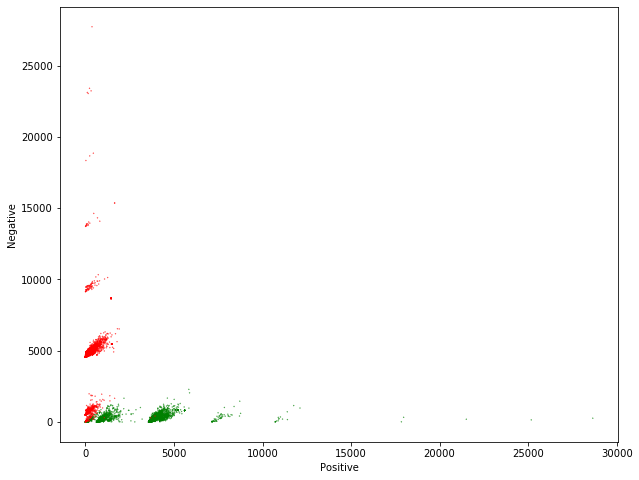

In [27]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (10, 8))

colors = ['red', 'green']

# Color based on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

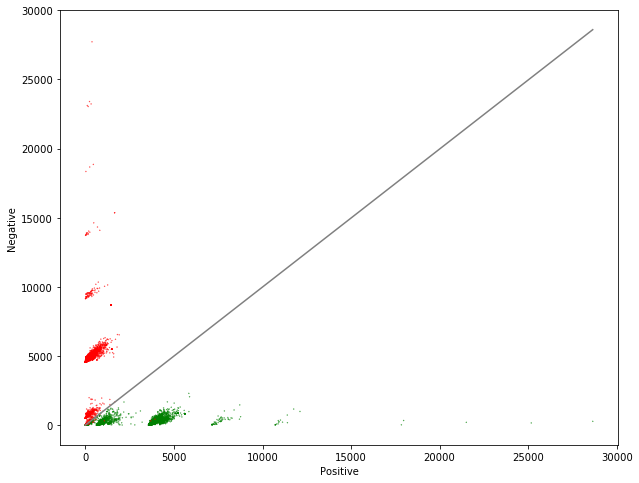

In [28]:
# Equation for the separation plane
def neg(theta, pos):
    return (-theta[0] - pos * theta[1]) / theta[2]

fig, ax = plt.subplots(figsize = (10, 8))

colors = ['red', 'green']

# Color base on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

# Now lets represent the logistic regression model in this chart. 
maxpos = np.max(X[:,1])           # max value in x-axis

# Plot a gray line that divides the 2 areas.
ax.plot([0,  maxpos], [neg(theta, 0),   neg(theta, maxpos)], color = 'gray') 

plt.show()

## LOGISTIC REGRESSION 

In [29]:
test_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {test_accuracy:.4f}")

Logistic regression model's accuracy = 0.9965


## NAIVE BAYES CLASSIFIER

In [43]:
logprior_naive, loglikelihood_naive = train_naive_bayes(freqs, train_x, train_y)
test_acc_naive = test_naive_bayes(test_x, test_y, logprior_naive, loglikelihood_naive)
print(f"Naive bayes classifier's accuracy = {test_acc_naive:.4f}")

Naive bayes classifier's accuracy = 0.5000
